### 개 고양이 소리 분류 신경망 만들기
* 고양이 소리 -> 숫자 변환 -> MFCC 로 음원 추출 -> 분류 신경망
* 숫자 변환 ~ MFCC : librosa 라이브러리 사용
<br>

* 고양이 소리 -> 숫자 변환 -> 스펙트럼 이미지 -> CNN 분류 신경망 : 가능은 하지만 성능 낮음
* 소리분류 : CNN < MFCC

In [23]:
import pandas as pd
import numpy as np
import glob # 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
import ntpath # 특정 경로에서 파일들을 가져오는 라이브러리

```
# colab 
from google.colab import drive
drive.mount('/content/drive')
Test_root = glob.glob('/content/drive/MyDrive/Colab Notebooks/cats_dogs/test')[0]
Train_root = glob.glob('/content/drive/MyDrive/Colab Notebooks/cats_dogs/train')[0]
```

In [24]:
train_root = glob.glob("C:/Data/archive/cats_dogs/train")[0]
test_root = glob.glob("C:/Data/archive/cats_dogs/test")[0]
x_path = glob.glob(train_root+"/cats/*") + glob.glob(train_root+"/dogs/*") + glob.glob(test_root+"/cats/*") + glob.glob(test_root+"/dogs/*")
print(len(x_path))

277


In [25]:
y = np.empty((0, 1, ))
for f in x_path: # dog, cat 데이터
    # 고양이 = 0,  개 = 1
    if 'cat' in ntpath.basename(f): #  음성 데이터가 있는 디렉토리의 데이터가 고양이 음성 데이터라면
        resp = np.array([0]).reshape(1, 1, )
        y = np.vstack((y, resp))  # resp 값을 y 배열에 append
    elif 'dog' in ntpath.basename(f): # 음성 데이터가 있는 디렉토리의 데이터가 개 음성 데이터라면
        resp = np.array([1]).reshape(1, 1, ) 
        y = np.vstack((y, resp))

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_path, y, test_size=0.25, random_state=42)

In [27]:
import IPython.display as ipd
ipd.Audio(x_train[0])

In [28]:
import librosa

# wav 파일 숫자로 변환
def librosa_read_wav_files(wav_files):
    if not isinstance(wav_files, list): # input 이 리스트 형태가 아니라면
        wav_files = [wav_files]
    return [librosa.load(f)[0] for f in wav_files] # librosa.load() : 숫자 변환 함수

In [29]:
wav_rate = librosa.load(x_train[0])[1] # sample rate 추출
x_train = librosa_read_wav_files(x_train)
x_test = librosa_read_wav_files(x_test)
print(x_train[0])

[-0.00637284 -0.00575956  0.0007889  ... -0.00333043 -0.00314497
 -0.00169598]


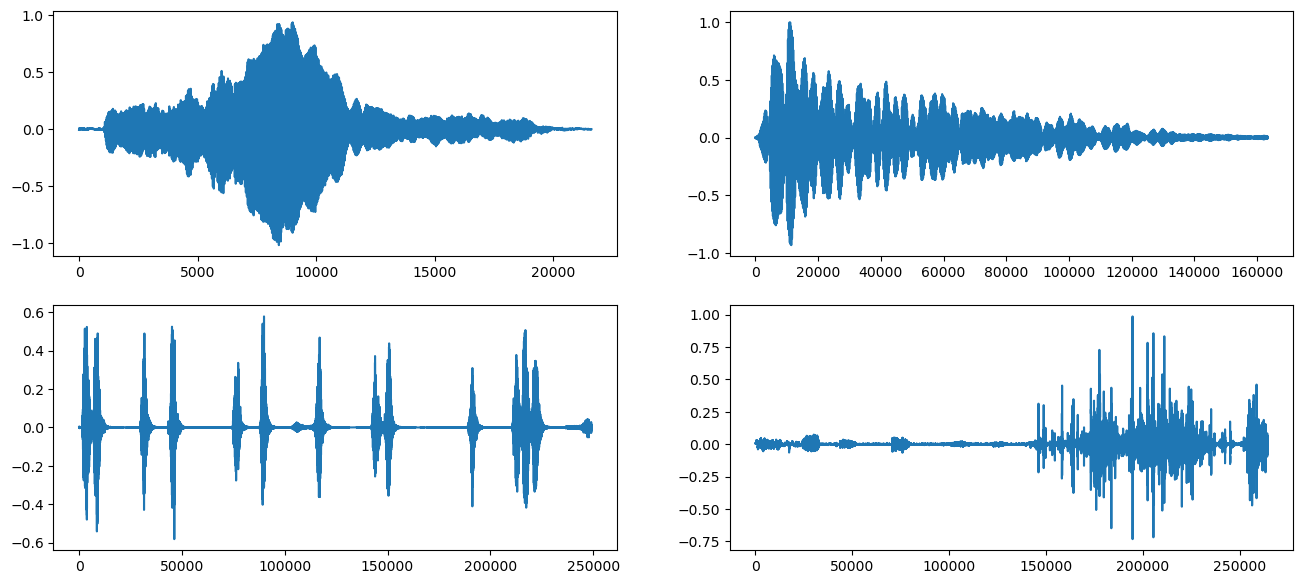

In [30]:
# 시각화
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(16, 7))
axs[0][0].plot(x_train[0])
axs[0][1].plot(x_train[1])
axs[1][0].plot(x_train[2])
axs[1][1].plot(x_train[3])
plt.show()

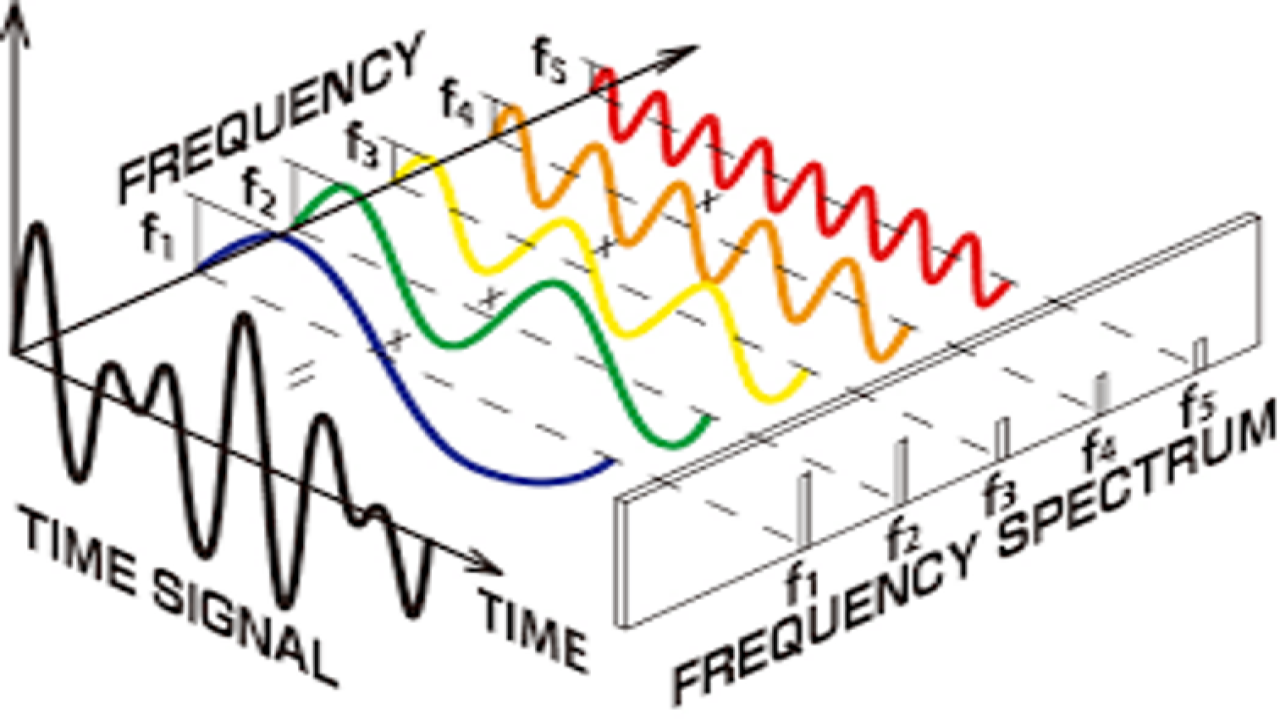

In [31]:
# MFCC로 소리의 주파스 스펙트럼 추출
def extract_features(audio_samples, sample_rate):
    extracted_features = np.empty((0, 41, )) # 0행 41열
    if not isinstance(audio_samples, list):
        audio_samples = [audio_samples]
        
    for sample in audio_samples:
        zero_cross_feat = librosa.feature.zero_crossing_rate(sample).mean() # 음성 신호 파형이 중심축(0)을 통과하는 횟수
        
        mfccs = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=40)  # mfcc : 주파수 추출 함수, 주파수 41 개 생성 (f1, f2, ...)
        mfccsscaled = np.mean(mfccs.T,axis=0) # 각 주파수의 평균값
        mfccsscaled = np.append(mfccsscaled, zero_cross_feat)
        mfccsscaled = mfccsscaled.reshape(1, 41, )
        extracted_features = np.vstack((extracted_features, mfccsscaled))
    return extracted_features

In [32]:
x_train_features = extract_features(x_train, wav_rate)
x_test_features = extract_features(x_test, wav_rate)

In [33]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

# one-hot encoding
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [34]:
# 신경망 모델 구현
model = models.Sequential()
# model.add(layers.Flatten(input_shape=(41, )))
model.add(layers.Dense(100, activation='relu', input_shape=(41, )))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               4200      
                                                                 
 batch_normalization_4 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 50)                5050      
                                                                 
 batch_normalization_5 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 50)               

In [35]:
# early stopping
best_model_weights = './base.model'

checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)

callbacks = [checkpoint]

model.compile(optimizer='adam',
              loss=losses.categorical_crossentropy,
              metrics=['accuracy'])

In [36]:
history = model.fit(
    x_train_features,
    train_labels,
    validation_data=(x_test_features,test_labels),
    epochs = 200, 
    verbose = 1,
    callbacks=callbacks,
)

Epoch 1/200
7/7 [==============================] - 1s 17ms/step - loss: 0.7189 - accuracy: 0.6522 - val_loss: 0.2502 - val_accuracy: 0.9143
Epoch 2/200
7/7 [==============================] - 0s 4ms/step - loss: 0.5343 - accuracy: 0.7923 - val_loss: 0.2481 - val_accuracy: 0.9286
Epoch 3/200
7/7 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.8309 - val_loss: 0.3072 - val_accuracy: 0.8571
Epoch 4/200
7/7 [==============================] - 0s 3ms/step - loss: 0.4047 - accuracy: 0.8454 - val_loss: 0.3549 - val_accuracy: 0.8286
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.3101 - accuracy: 0.8841 - val_loss: 0.3141 - val_accuracy: 0.8571
Epoch 6/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3379 - accuracy: 0.8986 - val_loss: 0.2759 - val_accuracy: 0.8714
Epoch 7/200
7/7 [==============================] - 0s 4ms/step - loss: 0.3107 - accuracy: 0.8599 - val_loss: 0.2268 - val_accuracy: 0.9000
Epoch 8/200
7/7 [=========

7/7 [==============================] - 0s 6ms/step - loss: 0.1504 - accuracy: 0.9324 - val_loss: 0.1402 - val_accuracy: 0.9429
Epoch 29/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2143 - accuracy: 0.9372 - val_loss: 0.1437 - val_accuracy: 0.9429
Epoch 30/200
7/7 [==============================] - 0s 6ms/step - loss: 0.2418 - accuracy: 0.8889 - val_loss: 0.1350 - val_accuracy: 0.9429
Epoch 31/200
7/7 [==============================] - 0s 2ms/step - loss: 0.1756 - accuracy: 0.9420 - val_loss: 0.1296 - val_accuracy: 0.9429
Epoch 32/200
7/7 [==============================] - 0s 3ms/step - loss: 0.1996 - accuracy: 0.9227 - val_loss: 0.1203 - val_accuracy: 0.9714
Epoch 33/200
7/7 [==============================] - 0s 5ms/step - loss: 0.1956 - accuracy: 0.9130 - val_loss: 0.1158 - val_accuracy: 0.9571
Epoch 34/200
7/7 [==============================] - 0s 3ms/step - loss: 0.1609 - accuracy: 0.9275 - val_loss: 0.1170 - val_accuracy: 0.9571
Epoch 35/200
7/7 [===============

7/7 [==============================] - 0s 3ms/step - loss: 0.1055 - accuracy: 0.9662 - val_loss: 0.1443 - val_accuracy: 0.9571
Epoch 57/200
7/7 [==============================] - 0s 5ms/step - loss: 0.1132 - accuracy: 0.9614 - val_loss: 0.1337 - val_accuracy: 0.9714
Epoch 58/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0883 - accuracy: 0.9758 - val_loss: 0.1224 - val_accuracy: 0.9714
Epoch 59/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1241 - accuracy: 0.9662 - val_loss: 0.1171 - val_accuracy: 0.9714
Epoch 60/200
7/7 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.9517 - val_loss: 0.1159 - val_accuracy: 0.9714
Epoch 61/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1140 - accuracy: 0.9565 - val_loss: 0.1160 - val_accuracy: 0.9714
Epoch 62/200
7/7 [==============================] - 0s 3ms/step - loss: 0.1136 - accuracy: 0.9614 - val_loss: 0.1165 - val_accuracy: 0.9714
Epoch 63/200
7/7 [===============

7/7 [==============================] - 0s 3ms/step - loss: 0.0961 - accuracy: 0.9614 - val_loss: 0.1326 - val_accuracy: 0.9571
Epoch 84/200
7/7 [==============================] - 0s 3ms/step - loss: 0.1050 - accuracy: 0.9469 - val_loss: 0.1312 - val_accuracy: 0.9571
Epoch 85/200
7/7 [==============================] - 0s 3ms/step - loss: 0.1064 - accuracy: 0.9565 - val_loss: 0.1293 - val_accuracy: 0.9571
Epoch 86/200
7/7 [==============================] - 0s 4ms/step - loss: 0.1172 - accuracy: 0.9565 - val_loss: 0.1262 - val_accuracy: 0.9571
Epoch 87/200
7/7 [==============================] - 0s 4ms/step - loss: 0.1267 - accuracy: 0.9565 - val_loss: 0.1079 - val_accuracy: 0.9571
Epoch 88/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0848 - accuracy: 0.9807 - val_loss: 0.1014 - val_accuracy: 0.9714
Epoch 89/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0962 - accuracy: 0.9662 - val_loss: 0.1043 - val_accuracy: 0.9714
Epoch 90/200
7/7 [===============

7/7 [==============================] - 0s 3ms/step - loss: 0.0814 - accuracy: 0.9710 - val_loss: 0.0884 - val_accuracy: 0.9714
Epoch 112/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0804 - accuracy: 0.9758 - val_loss: 0.0959 - val_accuracy: 0.9571
Epoch 113/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.9758 - val_loss: 0.1084 - val_accuracy: 0.9571
Epoch 114/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0489 - accuracy: 0.9855 - val_loss: 0.1143 - val_accuracy: 0.9571
Epoch 115/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0826 - accuracy: 0.9662 - val_loss: 0.1270 - val_accuracy: 0.9429
Epoch 116/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0747 - accuracy: 0.9758 - val_loss: 0.1377 - val_accuracy: 0.9286
Epoch 117/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0606 - accuracy: 0.9758 - val_loss: 0.1294 - val_accuracy: 0.9429
Epoch 118/200
7/7 [========

7/7 [==============================] - 0s 3ms/step - loss: 0.0538 - accuracy: 0.9855 - val_loss: 0.1027 - val_accuracy: 0.9571
Epoch 139/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0474 - accuracy: 0.9952 - val_loss: 0.1069 - val_accuracy: 0.9429
Epoch 140/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0667 - accuracy: 0.9758 - val_loss: 0.1110 - val_accuracy: 0.9571
Epoch 141/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0805 - accuracy: 0.9565 - val_loss: 0.1127 - val_accuracy: 0.9571
Epoch 142/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9855 - val_loss: 0.1300 - val_accuracy: 0.9286
Epoch 143/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0380 - accuracy: 0.9903 - val_loss: 0.1304 - val_accuracy: 0.9429
Epoch 144/200
7/7 [==============================] - 0s 3ms/step - loss: 0.1029 - accuracy: 0.9614 - val_loss: 0.1277 - val_accuracy: 0.9429
Epoch 145/200
7/7 [========

Epoch 166/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.9758 - val_loss: 0.1236 - val_accuracy: 0.9286
Epoch 167/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0345 - accuracy: 0.9903 - val_loss: 0.1276 - val_accuracy: 0.9143
Epoch 168/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0601 - accuracy: 0.9710 - val_loss: 0.1367 - val_accuracy: 0.9143
Epoch 169/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0727 - accuracy: 0.9662 - val_loss: 0.1521 - val_accuracy: 0.9143
Epoch 170/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0335 - accuracy: 0.9855 - val_loss: 0.1577 - val_accuracy: 0.9000
Epoch 171/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0467 - accuracy: 0.9855 - val_loss: 0.1506 - val_accuracy: 0.9000
Epoch 172/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 0.9807 - val_loss: 0.1383 - val_accuracy: 0.9286
Epoch 173/200

7/7 [==============================] - 0s 2ms/step - loss: 0.0486 - accuracy: 0.9758 - val_loss: 0.0863 - val_accuracy: 0.9571
Epoch 194/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0366 - accuracy: 0.9903 - val_loss: 0.0725 - val_accuracy: 0.9714
Epoch 195/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0334 - accuracy: 0.9952 - val_loss: 0.0652 - val_accuracy: 0.9714
Epoch 196/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.0708 - val_accuracy: 0.9714
Epoch 197/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0583 - accuracy: 0.9710 - val_loss: 0.0786 - val_accuracy: 0.9571
Epoch 198/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0530 - accuracy: 0.9807 - val_loss: 0.0790 - val_accuracy: 0.9571
Epoch 199/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0427 - accuracy: 0.9758 - val_loss: 0.0765 - val_accuracy: 0.9714
Epoch 200/200
7/7 [========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


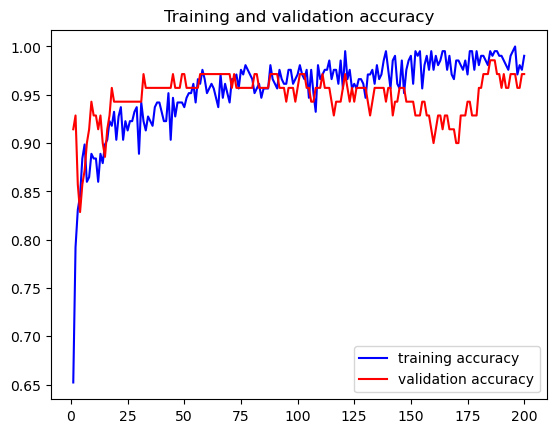

In [37]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label = "training accuracy")
plt.plot(epochs, val_acc, 'r', label = "validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [38]:
model.save_weights('model_wieghts.h5') # 가중치 데이터 저장
model.save('model_keras.h5') # 모델 저장

1/1 [==============================] - 0s 64ms/step
Cat: 0.984633207321167 Dog: 0.015366842038929462
This is a cat meowing


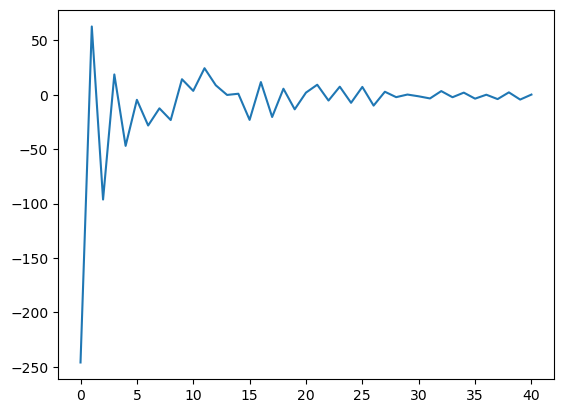

In [39]:
import IPython.display as ipd
nr_to_predict = 50
pred = model.predict(x_test_features[nr_to_predict].reshape(1, 41, ))
print("Cat: {} Dog: {}".format(pred[0][0], pred[0][1]))
if (y_test[nr_to_predict] == 0):
    print ("This is a cat meowing")
else:
    print ("This is a dog barking")
    
plt.plot(x_test_features[nr_to_predict])
ipd.Audio(x_test[nr_to_predict], rate=wav_rate)